In [1]:
import torch
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#plt.style.use(['notebook'])
import seaborn as sns
import pkbar
import time
import random

import tensorly as tl
from tensorly.decomposition import matrix_product_state, parafac
from tensorly.mps_tensor import mps_to_tensor
from tensorly.base import unfold, fold
from tensorly.kruskal_tensor import kruskal_to_tensor
tl.set_backend('pytorch')

import tensornetwork as tn
from tensornetwork import contractors
backend = 'pytorch'

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Grid World Setup

In [2]:
s, a = 25, 4

# states: scan from left to right
# actions: left, right, top, down
# in a reward of 10 and 5

R = torch.zeros((s, a)) 
for i in range(s):
    if i % 5 == 0:
        R[i, 0] = -1
    if (i - 4) % 5 == 0:
        R[i, 1] = -1
    if i in range(5):
        R[i, 2] = -1
    if i in range(s - 5, s):
        R[i, 3] = -1
R[1, :] = 10
R[3, :] = 5

R_vec = R.reshape(s * a)

In [3]:
R

tensor([[-1.,  0., -1.,  0.],
        [10., 10., 10., 10.],
        [ 0.,  0., -1.,  0.],
        [ 5.,  5.,  5.,  5.],
        [ 0., -1., -1.,  0.],
        [-1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [-1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [-1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.],
        [-1.,  0.,  0., -1.],
        [ 0.,  0.,  0., -1.],
        [ 0.,  0.,  0., -1.],
        [ 0.,  0.,  0., -1.],
        [ 0., -1.,  0., -1.]])

In [4]:
R_vec

tensor([-1.,  0., -1.,  0., 10., 10., 10., 10.,  0.,  0., -1.,  0.,  5.,  5.,
         5.,  5.,  0., -1., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0., -1.,
         0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0., -1.,
         0., -1.])

In [5]:
# s_t, a, s_(t+1)
P = torch.zeros((s, a, s)) 
for i in range(s):
    if i % 5 == 0:
        P[i, 0, i] = 1
    if (i - 4) % 5 == 0:
        P[i, 1, i] = 1
    if i in range(5):
        P[i, 2, i] = 1
    if i in range(s - 5, s):
        P[i, 3, i] = 1    

    for j in range(s):
        if j == i - 1:
            P[i, 0, j] = 1
        if j == i + 1:
            P[i, 1, j] = 1
        if j == i - 5:
            P[i, 2, j] = 1
        if j == i + 5:
            P[i, 3, j] = 1
    if i == 1:        
        P[i, :, :] = 0
        P[i, :, 21] = 1
    if i == 3:
        P[i, :, :] = 0
        P[i, :, 13] = 1

In [6]:
P

tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]],

        [[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]],

        [[0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0

In [7]:
P_mat = torch.empty((s, a, s, a))
for ss in range(s):
    for i in range(a):
        P_mat[:, :, ss, i] = P[:, :, ss]
P_mat = P_mat.reshape(s * a, s * a)

In [8]:
P_mat

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

In [9]:
target = torch.tensor(
 [[21.97748529, 24.4194281, 21.97748529, 19.4194281, 17.47748529],
 [19.77973676, 21.97748529, 19.77973676, 17.80176308, 16.02158677],
 [17.80176308, 19.77973676, 17.80176308, 16.02158677, 14.4194281],
 [16.02158677, 17.80176308, 16.02158677, 14.4194281, 12.97748529],
 [14.4194281, 16.02158677, 14.4194281, 12.97748529, 11.67973676]])

In [10]:
def explore_env(trajectories, k, R, P, s, a):
    seen = []
    omega = torch.zeros([s * a] * k)
    for t in range(trajectories):
        indices = torch.empty(2 * k)
        s_curr = np.random.randint(s)
        for num in range(2 * k):
            a_curr = np.random.randint(a)
            if (s_curr, a_curr) in seen:
                a_curr = np.random.randint(a)
            s_next = torch.argmax(P[s_curr, a_curr])
            indices[num] = s_curr * a + a_curr
            seen.append((s_curr, a_curr))
            s_next = s_curr
        for r in range(k):
            index = tuple(indices[r : r + k].to(int))
            omega[index] = 1
    return omega

In [11]:
target

tensor([[21.9775, 24.4194, 21.9775, 19.4194, 17.4775],
        [19.7797, 21.9775, 19.7797, 17.8018, 16.0216],
        [17.8018, 19.7797, 17.8018, 16.0216, 14.4194],
        [16.0216, 17.8018, 16.0216, 14.4194, 12.9775],
        [14.4194, 16.0216, 14.4194, 12.9775, 11.6797]])

In [12]:
def explore(Q, a, eps, ss):
    choice = np.random.uniform()
    if choice < eps:
        return np.random.randint(a)
    else:
        return np.argmax(Q[ss])

def Q_learning(five_tuple, lr=0.05, epochs=5000, gamma=0.5):
    Q_history = []
    Q = np.zeros((s, a))
    ss = np.random.randint(s)
    aa = np.random.randint(a)
    
    for _ in range(epochs):    
        Q_history.append(np.sum(Q))
        new_s = np.argmax(P[ss, aa])
        Q[ss, aa] += lr * (R[ss, aa] + gamma * np.max(Q[new_s, :]) - Q[ss, aa])
        ss = new_s.item()
        aa = explore(Q, a, 0.2, ss)
            
    return Q, Q_history

In [14]:
k = 3
s, a = 25, 4
gamma = 0.9
chi = 10
omega = explore_env(10000, k, R, P, s, a)
# omega = torch.ones([s * a] * k)
five_tuple = s, a, P_mat, R_vec, gamma 

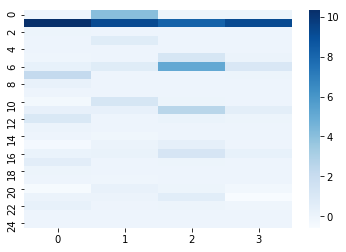

In [15]:
Q, Q_hist = Q_learning(five_tuple)
ax = sns.heatmap(Q, cmap="Blues")
plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


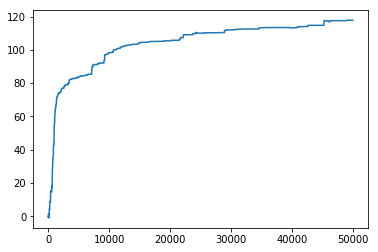

In [16]:
Q, Q_hist = Q_learning(five_tuple, lr=0.5, epochs=50000)
plt.plot(Q_hist)
plt.legend()

In [17]:
policy = torch.empty(s)
p = torch.tensor(Q)
for i in range(s):
    policy[i] = torch.argmax(p[i, :])
policy.reshape(5, 5)

tensor([[1., 3., 0., 0., 0.],
        [1., 2., 0., 0., 2.],
        [2., 2., 2., 0., 2.],
        [2., 2., 2., 0., 0.],
        [1., 2., 2., 0., 0.]])

In [18]:
P_mat

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

In [19]:
R_vec

tensor([-1.,  0., -1.,  0., 10., 10., 10., 10.,  0.,  0., -1.,  0.,  5.,  5.,
         5.,  5.,  0., -1., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0., -1.,
         0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0., -1.,
         0., -1.])

In [20]:
from DQN import ReplayMemory, Transition, hidden_unit, Q_learning
from torch.autograd import Variable
from gridworld import *
import torch.optim as optim
import torch


In [21]:
epochs = 1000
gamma = 0.9 #since it may take several moves to goal, making gamma high
epsilon = 1
model = Q_learning(64, [150,150], 4, hidden_unit)
optimizer = optim.RMSprop(model.parameters(), lr = 1e-2)
# optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum = 0)
criterion = torch.nn.MSELoss()
buffer = 80
BATCH_SIZE = 40
memory = ReplayMemory(buffer)   

In [22]:
for i in range(epochs):
    state = initGridPlayer()
    status = 1
    step = 0
    #while game still in progress
    while(status == 1):   
        v_state = Variable(torch.from_numpy(state)).view(1,-1)
        qval = model(v_state)
        if (np.random.random() < epsilon): #choose random action
            action = np.random.randint(0,4)
        else: #choose best action from Q(s,a) values
            action = np.argmax(qval.data)
        #Take action, observe new state S'
        new_state = makeMove(state, action)
        step +=1
        v_new_state = Variable(torch.from_numpy(new_state)).view(1,-1)
        #Observe reward
        reward = getReward(new_state)
        memory.push(v_state.data, action, v_new_state.data, reward)
        if (len(memory) < buffer): #if buffer not filled, add to it
            state = new_state
            if reward != -1: #if reached terminal state, update game status
                break
            else:
                continue
        transitions = memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        state_batch = Variable(torch.cat(batch.state))
        action_batch = Variable(torch.LongTensor(batch.action)).view(-1,1)
        new_state_batch = Variable(torch.cat(batch.new_state))
        reward_batch = Variable(torch.FloatTensor(batch.reward))
        non_final_mask = (reward_batch == -1)
        #Let's run our Q function on S to get Q values for all possible actions
        qval_batch = model(state_batch)
        # we only grad descent on the qval[action], leaving qval[not action] unchanged
        state_action_values = qval_batch.gather(1, action_batch)
        #Get max_Q(S',a)
        with torch.no_grad():
            newQ = model(new_state_batch)
        maxQ = newQ.max(1)[0]
#         if reward == -1: #non-terminal state
#             update = (reward + (gamma * maxQ))
#         else: #terminal state
#             update = reward + 0*maxQ
#         y = reward_batch + (reward_batch == -1).float() * gamma *maxQ
        y = reward_batch
        y[non_final_mask] += gamma * maxQ[non_final_mask]
        y = y.view(-1,1)
        print("Game #: %s" % (i,), end='\r')
        loss = criterion(state_action_values, y)
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        for p in model.parameters():
            p.grad.data.clamp_(-1, 1)
        optimizer.step()
        state = new_state
        if reward != -1:
            status = 0
        if step >20:
            break
    if epsilon > 0.1:
        epsilon -= (1/epochs)

In [27]:
## Here is the test of AI
def testAlgo(init=0):
    i = 0
    if init==0:
        state = initGrid()
    elif init==1:
        state = initGridPlayer()
    elif init==2:
        state = initGridRand()

    print("Initial State:")
    print(dispGrid(state))
    status = 1
    #while game still in progress
    while(status == 1):
        v_state = Variable(torch.from_numpy(state))
        qval = model(v_state.view(64))
        print(qval)
        action = np.argmax(qval.data) #take action with highest Q-value
        print('Move #: %s; Taking action: %s' % (i, action))
        state = makeMove(state, action)
        print(dispGrid(state))
        reward = getReward(state)
        if reward != -1:
            status = 0
            print("Reward: %s" % (reward,))
        i += 1 #If we're taking more than 10 actions, just stop, we probably can't win this game
        if (i > 10):
            print("Game lost; too many moves.")
            break


testAlgo(init=1)

Initial State:
[[' ' ' ' ' ' ' ']
 ['P' '-' '+' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
tensor([[ 4.5773,  1.7455,  3.0706, -6.2458]], grad_fn=<AddmmBackward>)
Move #: 0; Taking action: tensor(0)
[['P' ' ' ' ' ' ']
 [' ' '-' '+' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
tensor([[5.0168, 1.5092, 4.5646, 6.2072]], grad_fn=<AddmmBackward>)
Move #: 1; Taking action: tensor(3)
[[' ' 'P' ' ' ' ']
 [' ' '-' '+' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
tensor([[ 6.6429, -6.7476,  4.5527,  8.0089]], grad_fn=<AddmmBackward>)
Move #: 2; Taking action: tensor(3)
[[' ' ' ' 'P' ' ']
 [' ' '-' '+' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
tensor([[7.9861, 9.9781, 6.5986, 6.5172]], grad_fn=<AddmmBackward>)
Move #: 3; Taking action: tensor(1)
[[' ' ' ' ' ' ' ']
 [' ' '-' ' ' ' ']
 [' ' ' ' 'W' ' ']
 [' ' ' ' ' ' ' ']]
Reward: 10
